In [12]:
import matplotlib.pyplot as plt
from viznet import NodeBrush, EdgeBrush, CLinkBrush

def _show():
    plt.axis('off')
    plt.axis('equal')
    plt.show()

# Basic Operations

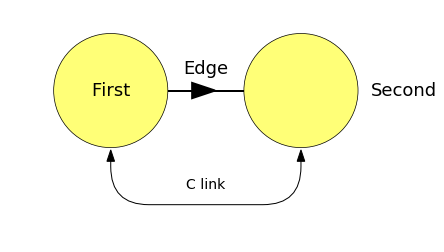

In [21]:
brush = NodeBrush('nn.input', size='normal')
edge = EdgeBrush('->-', lw=2)

# paint a node at (x=1, y=0)
node1 = brush >> (1,0)
node2 = brush >> (2,0)
# add texts to nodes
node1.text('First', 'center', fontsize=18)
node2.text('Second', 'right', fontsize=18)

# connect two nodes
e12 = edge >> (node1, node2)
e12.text('Edge', 'top', fontsize=18)

# use C link
clink = CLinkBrush('<->', offsets=(-0.3,), roundness=0.2)
cl = clink >> (node1.pin('bottom'), node2.pin('bottom'))
cl.text('C link', 'top', fontsize=14)

_show()